In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import keras_tuner as kt

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os

from collections import Counter


# **Data loading**

In [2]:
NB_SENSOR_CHANNELS = 24  # 6 sensors × 4 quaternion features
NUM_CLASSES = 11  #based on gesture categories
SLIDING_WINDOW_LENGTH = 32  # Larger window for meaningful motion
FINAL_SEQUENCE_LENGTH = 8
SLIDING_WINDOW_STEP = 16  #Overlapping steps for smoother motion tracking
BATCH_SIZE = 64  #Balances performance vs. memory usage
NUM_FILTERS = 128  # More feature extraction from IMU data , can be tuned dynamically
FILTER_SIZE = 5  # Keeps local motion patterns intact, can be tuned dynamically
NUM_UNITS_LSTM = 128  # Memory capacity for tracking movement transitions

In [9]:
annotated_dir = "./processed/annotated/"
os.listdir(annotated_dir)

['participant_01.csv',
 'participant_02.csv',
 'participant_03.csv',
 'participant_04.csv',
 'participant_05.csv',
 'participant_06.csv',
 'participant_07.csv',
 'participant_08.csv',
 'participant_09.csv',
 'participant_10.csv']

In [7]:
def add_gaussian_noise(data, noise_factor=0.01):
    augmented_data = data.copy()
    quat_cols = [col for col in augmented_data.columns if 'Quat' in col]
    augmented_data[quat_cols] += noise_factor * np.random.randn(*augmented_data[quat_cols].shape)
    return augmented_data

In [10]:
test_participant = 2
data_frames = []
for idx,file in enumerate(os.listdir(annotated_dir)):
    if idx != test_participant-1:
        data_frames.append(add_gaussian_noise(pd.read_csv(os.path.join(annotated_dir, file))))
        print(file)
df = pd.concat(data_frames, ignore_index=True)

participant_01.csv
participant_03.csv
participant_04.csv
participant_05.csv
participant_06.csv
participant_07.csv
participant_08.csv
participant_09.csv
participant_10.csv


In [11]:
def load_imu_data(df):
    #normalize quaternion features
    quaternion_cols = [col for col in df.columns if 'Quat' in col]
    scaler = StandardScaler()
    df[quaternion_cols] = scaler.fit_transform(df[quaternion_cols])

    #encoding activity labels
    label_encoder = LabelEncoder()
    df['Activity'] = label_encoder.fit_transform(df['Activity'])

    return df, label_encoder

def create_sequences(df, sequence_length=32, step=SLIDING_WINDOW_STEP):
    X, y = [], []
    quaternion_cols = [col for col in df.columns if 'Quat' in col]  # Extract quaternion features

    for i in range(0, len(df) - sequence_length + 1, step):
        X.append(df[quaternion_cols].iloc[i:i+sequence_length].values)  # Extract sensor data window
        
        # Find the most frequent activity label in the current window
        activity_window = df['Activity'].iloc[i:i+sequence_length]
        most_frequent_activity = Counter(activity_window).most_common(1)[0][0]  # Get mode
        
        y.append(most_frequent_activity)  # Assign dominant activity

    return np.array(X), np.array(y)

In [12]:
df, label_encoder = load_imu_data(df)
X, y = create_sequences(df, sequence_length = SLIDING_WINDOW_LENGTH, step= SLIDING_WINDOW_STEP)

In [13]:
df.head()

,Timestamp,QuatI_0,QuatJ_0,QuatK_0,QuatSum_0,QuatI_1,QuatJ_1,QuatK_1,QuatSum_1,QuatI_2,...,QuatSum_3,QuatI_4,QuatJ_4,QuatK_4,QuatSum_4,QuatI_5,QuatJ_5,QuatK_5,QuatSum_5,Activity
0,0.000,0.444463,-0.203656,0.376715,0.212354,-1.155308,-0.189272,-1.281550,-1.603075,-1.481309,...,-1.288452,-2.009088,1.862348,-2.636728,-1.822716,0.544193,-0.759360,0.346093,1.449398,0
1,0.035,0.419753,-0.160415,0.277738,0.178290,-1.182595,1.702787,-1.625480,-1.339489,-1.362591,...,0.935271,0.640499,-0.486578,0.568391,0.245717,-1.213563,-0.104414,-1.152235,-1.296494,0
2,0.073,0.530383,-0.231509,0.196832,0.185625,-1.146539,1.695561,-1.548611,-1.349888,-1.359683,...,0.911538,0.784931,-0.508427,0.544048,0.270118,-1.236510,-0.136167,-1.184027,-1.345278,0
3,0.107,0.457452,-0.188186,0.326348,0.204143,0.569996,-0.577367,1.073261,0.407027,-1.061757,...,-1.328673,-1.670437,2.183351,-2.570221,-1.803770,-1.463926,1.925372,-1.512007,-1.123320,0
4,0.135,0.569234,-0.220286,0.184153,0.251239,-1.176915,1.703287,-1.573396,-1.327933,-1.335778,...,0.911217,0.664367,-0.537041,0.565433,0.237719,-1.222747,-0.105438,-1.160808,-1.288855,0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=7,)

In [14]:
testfile = pd.read_csv((os.path.join(annotated_dir, os.listdir(annotated_dir)[test_participant-1])))
print(os.listdir(annotated_dir)[test_participant-1])

participant_02.csv


In [15]:
testfile, label_encoder = load_imu_data(testfile)
X_test, y_test = create_sequences(testfile, sequence_length = SLIDING_WINDOW_LENGTH)

In [16]:
X_test[:5], y_test[:5]

(array([[[ 0.00000000e+00,  2.22044605e-16, -1.11022302e-16, ...,
          -4.20014884e-01,  2.36023971e-01, -8.75045266e-01],
         [ 0.00000000e+00,  2.22044605e-16, -1.11022302e-16, ...,
          -4.20014884e-01,  2.36023971e-01, -8.75045266e-01],
         [ 0.00000000e+00,  2.22044605e-16, -1.11022302e-16, ...,
          -4.19543759e-01,  2.36821820e-01, -8.75023551e-01],
         ...,
         [ 0.00000000e+00,  2.22044605e-16, -1.11022302e-16, ...,
          -4.86719827e-01,  7.34392511e-01,  5.48205077e-01],
         [ 0.00000000e+00,  2.22044605e-16, -1.11022302e-16, ...,
          -4.19589178e-01,  2.38733585e-01, -8.72879639e-01],
         [ 0.00000000e+00,  2.22044605e-16, -1.11022302e-16, ...,
          -4.19589178e-01,  2.38733585e-01, -8.72879639e-01]],
 
        [[ 0.00000000e+00,  2.22044605e-16, -1.11022302e-16, ...,
          -4.19451204e-01,  2.37929202e-01, -8.73995032e-01],
         [ 0.00000000e+00,  2.22044605e-16, -1.11022302e-16, ...,
          -4.19492112

# **Modelling the architecture of the network**

In [17]:
model1 = models.Sequential()

In [18]:
# Input Layer
model1.add(layers.Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))  # (Batch, Time, Features, Channels)

# Convolutional Layers (Deep CNN Feature Extraction)
model1.add(layers.Conv2D(NUM_FILTERS, (FILTER_SIZE, 1), activation='relu'))
model1.add(layers.Conv2D(NUM_FILTERS, (FILTER_SIZE, 1), activation='relu'))
model1.add(layers.Conv2D(NUM_FILTERS, (FILTER_SIZE, 1), activation='relu'))
model1.add(layers.Conv2D(NUM_FILTERS, (FILTER_SIZE, 1), activation='relu'))

# Reshape for LSTM input (Time, Features)
model1.add(layers.Reshape((-1, NUM_FILTERS)))  # Removing channel dimension

# LSTM Layers (Shallow LSTMs for Temporal Processing)
model1.add(layers.LSTM(NUM_UNITS_LSTM, return_sequences=True))
model1.add(layers.LSTM(NUM_UNITS_LSTM, return_sequences=False))  # Last LSTM outputs final sequence

# Dense Layer for classification
model1.add(layers.Dense(NUM_CLASSES, activation='softmax'))  # Probability distribution over classes

In [19]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 24, 128)         │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 24, 128)         │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 24, 128)         │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 384, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 384, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 511,499 (1.95 MB)

 Trainable params: 511,499 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

# **Model Training**

In [20]:
history = model1.fit(
    X, y,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
    ]
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.1647 - loss: 2.3122 - val_accuracy: 0.1562 - val_loss: 2.2583 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.1840 - loss: 2.2574 - val_accuracy: 0.2156 - val_loss: 2.2381 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.1946 - loss: 2.2279 - val_accuracy: 0.2031 - val_loss: 2.2400 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.2472 - loss: 2.1053 - val_accuracy: 0.2062 - val_loss: 2.2040 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.3518 - loss: 1.9297 - val_accuracy: 0.3063 - val_loss: 2.0915 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.4374 - loss: 1.7244 - val_accuracy: 0.3250 - val_loss: 2.0159 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4862 - loss: 1.5627 - val_accuracy: 

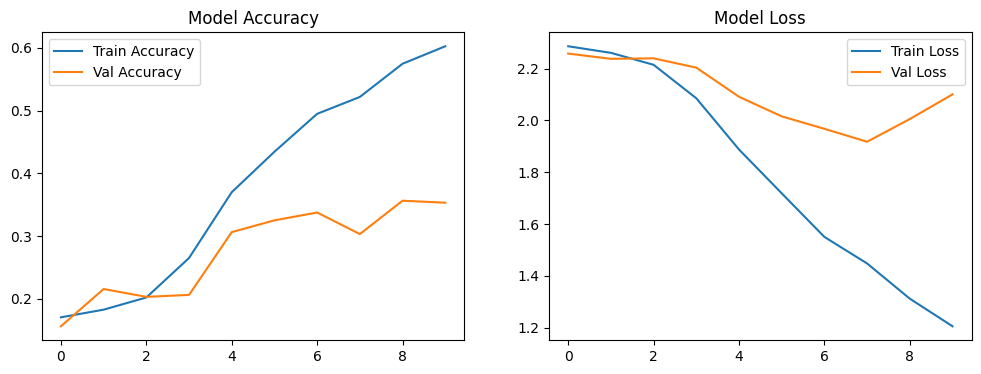

In [21]:
# Plot Accuracy & Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Model Loss")

plt.show()

In [22]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.3173 - loss: 1.8699
Test Accuracy: 0.3031, Test Loss: 1.9179


In [21]:
model1.save("final_imu_model.h5")  # Saves the trained model